# explore the BOKU NDVI data -> VCI3M

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [4]:
EXPERIMENT =      'one_month_forecast_BOKU_VCI3M_adede_only_vars'
TRUE_EXPERIMENT = 'one_month_forecast_BOKU_VCI3M_adede_only_vars'
TARGET_VAR =      'VCI3M'

# Read in the data

In [5]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [6]:
print("ALL DATA:")
display(ds)
print('\n\n')
print("TARGET VARIABLE:")
display(y_test)

assert TARGET_VAR == [v for v in y_test.data_vars][0]

ALL DATA:


<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 203)
Coordinates:
  * time     (time) datetime64[ns] 2002-02-28 2002-03-31 ... 2018-12-31
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
Data variables:
    VCI3M    (time, lat, lon) float64 87.53 75.55 82.85 ... 58.68 73.7 48.96
    RCI1M    (time, lat, lon) float64 35.09 33.36 34.83 49.54 ... nan nan nan
    RCI3M    (time, lat, lon) float64 64.47 72.84 69.39 74.83 ... nan nan nan
    RFE1M    (time, lat, lon) float64 84.34 85.12 91.79 122.2 ... nan nan nan
    RFE3M    (time, lat, lon) float64 124.6 135.2 144.2 147.6 ... nan nan nan
    SPI1     (time, lat, lon) float64 -1.179 -0.9577 -0.7458 ... nan nan nan
    SPI3     (time, lat, lon) float64 -0.446 -0.005104 0.07086 ... nan nan nan
    VCI1M    (time, lat, lon) float64 100.0 77.08 86.54 100.0 ... nan nan nan




TARGET VARIABLE:


<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 36)
Coordinates:
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * time     (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    VCI3M    (time, lat, lon) float64 57.26 48.9 63.41 ... 58.68 73.7 48.96

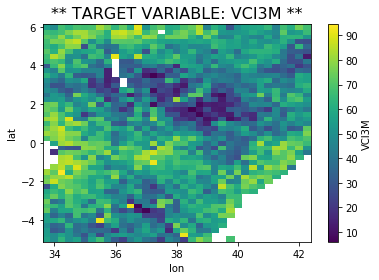

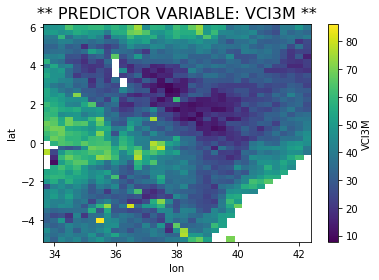

In [28]:
fig, ax = plt.subplots()
y_test.isel(time=0)[TARGET_VAR].plot(ax=ax)
ax.set_title(f"** TARGET VARIABLE: {TARGET_VAR} **", size=16)

for var in [TARGET_VAR]:  # [v for v in X_test.data_vars]:
    fig, ax = plt.subplots()
    X_train.mean(dim='time')[var].plot(ax=ax)
    ax.set_title(f"** PREDICTOR VARIABLE: {var} **", size=16)

In [10]:
from src.utils import get_ds_mask
# mask = get_ds_mask(X_train)

bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1] # .where(~mask)
lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1]  #.where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1]  # .where(~mask)

Text(0.5, 1.0, '** PREDICTED VALUES **')

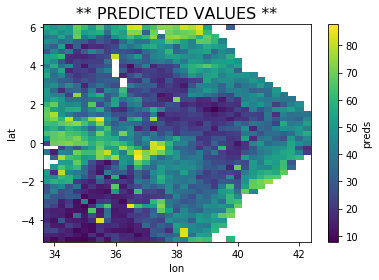

In [15]:
fig, ax = plt.subplots()
lstm_pred.isel(time=-1).plot(ax=ax)
ax.set_title("** PREDICTED VALUES **", size=16)

### Model Performance Data

In [19]:
from src.analysis import spatial_rmse, spatial_r2

# -------- LSTM
lstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    lstm_pred.transpose("time", "lat", "lon")
)

# -------- EALSTM
ealstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)

# -------- Baseline
bline_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)


# calculate mean performance scores
lstm_mean = lstm_rmse.mean().values
ealstm_mean = ealstm_rmse.mean().values
bline_mean = bline_rmse.mean().values

print("lstm_mean RMSE: ".ljust(20), f"{lstm_mean:.2f}")
print("ealstm_mean RMSE: ".ljust(20), f"{ealstm_mean:.2f}")
print("bline_mean RMSE: ".ljust(20), f"{bline_mean:.2f}")

lstm_mean RMSE:      4.36
ealstm_mean RMSE:    4.23
bline_mean RMSE:     11.23


# Model Performance

In [20]:
print("lstm_mean RMSE: ".ljust(20), f"{lstm_mean:.2f}")
print("ealstm_mean RMSE: ".ljust(20), f"{ealstm_mean:.2f}")
print("bline_mean RMSE: ".ljust(20), f"{bline_mean:.2f}")

lstm_mean RMSE:      4.36
ealstm_mean RMSE:    4.23
bline_mean RMSE:     11.23


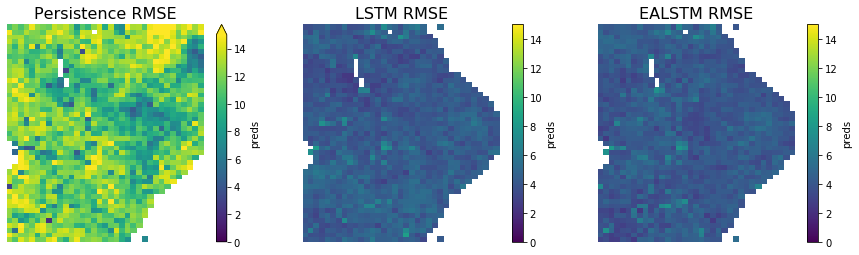

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
kwargs = {'vmin': 0, 'vmax': 15}

bline_rmse.plot(ax=axs[0], **kwargs)
axs[0].set_title('Persistence RMSE', size=16);

lstm_rmse.plot(ax=axs[1], **kwargs)
axs[1].set_title('LSTM RMSE', size=16);

ealstm_rmse.plot(ax=axs[2], **kwargs)
axs[2].set_title('EALSTM RMSE', size=16);

for ax in axs:
    ax.set_axis_off()

### Error over time

In [ ]:
def calculate_error(true_da, pred_da, method=None):
    if method == 'squared':
        vals = (true_da.values - pred_da.values) ** 2
    elif method == 'absolute':
        vals = abs((true_da.values - pred_da.values))
    else:
        vals = (true_da.values - pred_da.values)
    da = xr.ones_like(true_da) * vals
    return da.rename(f'{method + "_" if method is not None else ""}error')


ealstm_error = calculate_error(
    pred_da=ealstm_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)
lstm_error = calculate_error(
    pred_da=lstm_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)
bline_error = calculate_error(
    pred_da=bline_pred.transpose("time", "lat", "lon"),
    true_da=y_test[TARGET_VAR].transpose("time", "lat", "lon"),
    method='squared'
)

In [ ]:
import calendar 
mths = [m for m in calendar.month_abbr]
fig, ax = plt.subplots(figsize=(12, 6))

bline_error.groupby('time.month').mean().plot(ax=ax, label='Persistence')
lstm_error.groupby('time.month').mean().plot(ax=ax, label='LSTM')
ealstm_error.groupby('time.month').mean().plot(ax=ax, label='EALSTM')
plt.legend()

ax.set_title(f'Seasonality of Model Error {TARGET_VAR}', size=16);
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)
ax.set_ylabel(bline_error.name, size=14)
fig.savefig(f'/Users/tommylees/Downloads/model_error_seasonality_{TARGET_VAR}.png');

#### How does persistence error vary and how does that correspond with the raw NDVI values?

Note: the interpretation of this error is always slightly difficult because the VCI is de-seasonalised and so we do not expect to find any seasonal pattern in the VCI (nor necessarily our results)...

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
mths = [m for m in calendar.month_abbr]

# normalise the NDVI seasonality
(
    (ds.modis_ndvi.groupby('time.month').mean() - ds.modis_ndvi.mean()) / ds.modis_ndvi.std()
).plot(ax=ax, label='Raw Mean NDVI', color='grey', ls='--')


# normalise the persistence model error seasonality (Error)
(
    (bline_error.groupby('time.month').mean() - bline_error.mean()) / bline_error.std()
).plot(ax=ax, label='Persistence Squared Error')

ax.set_title(f'Seasonality of Model Error compared with Raw NDVI ({TARGET_VAR})', size=16);
ax.set_ylabel('Normalised Values [ $(x - \mu) / \sigma$ ]', size=14)
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)
plt.legend();
fig.savefig(f'/Users/tommylees/Downloads/model_error_seasonality_{TARGET_VAR}.png')

### What if we compare our VCI products? 
It looks pretty fucked truth be told. It looks like the BOKU VCI must have an error in the calculation

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ds.boku_VCI.groupby('time.month').mean().plot(ax=ax, label='BOKU VCI')
ds.VCI.groupby('time.month').mean().plot(ax=ax, label='NOAA VCI')
ds.VCI3M.groupby('time.month').mean().plot(ax=ax, label='VCI3M')
ax.set_title(f'Comparison of VCI Products', size=16);
ax.set_ylim([0, 100])
plt.legend();

fig.savefig(plot_dir / f'VCI_product_seasonality.png')

### Have we normalised the seasonality?

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
mths = [m for m in calendar.month_abbr]

# normalise the NDVI seasonality
(
    (ds.modis_ndvi.groupby('time.month').mean() - ds.modis_ndvi.mean()) / ds.modis_ndvi.std()
).plot(ax=ax, label='Raw Mean NDVI', color='grey', ls='--')


# normalise the BOKU VCI
(
    (ds.boku_VCI.groupby('time.month').mean() - ds.boku_VCI.mean()) / ds.boku_VCI.std()   
).plot(ax=ax, label='BOKU VCI')

# normalise the NOAA VCI seasonality (Error)
(
    (ds.VCI.groupby('time.month').mean() - ds.VCI.mean()) / ds.VCI.std()   
).plot(ax=ax, label='NOAA VCI')


ax.set_title('Seasonality of BOKU VCI compared with Raw NDVI', size=16);
ax.set_ylabel('Normalised Values [ $(x - \mu) / \sigma$ ]', size=14)
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)
plt.legend();
fig.savefig('/Users/tommylees/Downloads/model_VCI_NDVI_seasonality.png')

# Region Analysis

In [ ]:
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(
    data_dir=data_dir,
    experiment=EXPERIMENT,
    true_data_experiment=TRUE_EXPERIMENT
)
r = RegionGeoPlotter(data_dir)

In [ ]:
region_path = analyzer.region_data_paths[0]
admin_level_name = region_path.name.replace('.nc', '')
region_da, region_lookup, region_group_name = analyzer.load_region_data(region_path)
valid_region_ids = [k for k in region_lookup.keys()]

In [ ]:
def get_region_mask(region: str):
    lookup = dict(zip(region_lookup.values(), region_lookup.keys()))
    region_id = lookup[region]
    
    return ~region_da.where(region_da == region_id).isnull()

In [ ]:
import calendar
mths = [m for m in calendar.month_abbr if m != ""]

colors = ['blue', 'red', 'grey', 'yellow']
regions = ["MANDERA", "MARSABIT", "TURKANA", "WAJIR"]
fig, ax = plt.subplots(figsize=(12, 6))
for ix, region in enumerate(regions):
    msk = get_region_mask(region)
    df = ds.modis_ndvi.where(msk).groupby('time.month').mean().to_dataframe().set_index(pd.Series(mths)).rename(columns={'modis_ndvi': region})

    df.plot(ax=ax, color=colors[ix])

ax.set_ylim([0, 0.5])
ax.set_xticks([i for i in range(0, 12)])
ax.set_xticklabels(mths)
plt.legend()
ax.set_title('Average NDVI Seasonality in Districts', size=16);


### Make region dataframe

In [ ]:
import pickle

analyzer.analyze()

In [ ]:
region_plotter = analyzer.create_model_performance_by_region_geodataframe()
df = analyzer.df
gdf = region_plotter.gdf

In [ ]:
all_gdf = region_plotter.merge_all_model_performances_gdfs(analyzer.df)
all_gdf.head()

### Seasonality of Performance?

In [ ]:
# all_gdf.loc[(all_gdf.model == 'previous_month') & (all_gdf.region_name == 'TURKANA')]
fig, ax = plt.subplots(figsize=(12, 6))
ts = all_gdf.loc[(all_gdf.model == 'previous_month')].groupby('datetime').mean()
ts.groupby(ts.index.month).mean().rename(columns={'predicted_mean_value': 'Persistence Prediction'}).plot(ax=ax)
ax.set_title(f'Persistence Model compared with the True Values [spatially aggregated]\n[{TARGET_VAR}]', size=16);
ax.set_ylabel('VCI ', size=15)

mths = [m for m in calendar.month_abbr]
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)

fig.savefig(f'/Users/tommylees/Downloads/persistence_model_seasonality_{TARGET_VAR}.png')

In [ ]:
# all_gdf.loc[(all_gdf.model == 'previous_month') & (all_gdf.region_name == 'TURKANA')]
fig, ax = plt.subplots(figsize=(12, 6))
ts = all_gdf.loc[(all_gdf.model == 'rnn')].groupby('datetime').mean()
ts.groupby(ts.index.month).mean().rename(columns={'predicted_mean_value': 'LSTM Prediction'}).plot(ax=ax)
ax.set_title(f'LSTM compared with the True Values [spatially aggregated]\n[{TARGET_VAR}]', size=16);
ax.set_ylabel('VCI ', size=15)

mths = [m for m in calendar.month_abbr]
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)


fig.savefig(f'/Users/tommylees/Downloads/lstm_model_seasonality_{TARGET_VAR}.png')

In [ ]:
# all_gdf.loc[(all_gdf.model == 'previous_month') & (all_gdf.region_name == 'TURKANA')]
fig, ax = plt.subplots(figsize=(12, 6))
ts = all_gdf.loc[(all_gdf.model == 'rnn')].groupby('datetime').mean()
ts.groupby(ts.index.month).mean().rename(columns={'predicted_mean_value': 'EALSTM Prediction'}).plot(ax=ax)
ax.set_title(f'EALSTM compared with the True Values [spatially aggregated]\n[{TARGET_VAR}]', size=16);
ax.set_ylabel('VCI ', size=15)

mths = [m for m in calendar.month_abbr]
ax.set_xticks([i for i in range(0, 13)])
ax.set_xticklabels(mths)

fig.savefig(f'/Users/tommylees/Downloads/ealstm_model_seasonality_{TARGET_VAR}.png')

# Paper Analysis

### Q1: RMSE for each District

In [ ]:
from typing import Tuple, List, Dict, Optional

def analyze_region(
        region_name: str, 
        district_map: xr.Dataset, 
        model_experiment: str, 
        true_data_experiment: str,
        model: str,
        target_var: str = 'VCI') -> Tuple[float, float]:

    region_lookup: Dict = dict(
            zip(
                [v.strip() for v in district_map.attrs["values"].split(",")],
                [int(k.strip()) for k in district_map.attrs["keys"].split(",")],
            )
        )
    
    district_int = region_lookup[region_name]
    
    rmse: List[np.ndarray] = []
    
    for file_name in (data_dir / 'features' / true_data_experiment / 'test').glob("*"):
        year, month = file_name.name.split("_")
        
        # read the observed (true) data
        true_file = xr.open_dataset(file_name / "y.nc").where(
            district_map.district_l2 == district_int).rename({target_var: "preds"}
        ).isel(time=0)

        # read predictions
        model_file = xr.open_dataset(
            data_dir / 'models' / model_experiment / model / f"preds_{year}_{month}.nc"
        ).where(district_map.district_l2 == district_int)
        
        model_err = (model_file - true_file).preds.values
        model_err = model_err[~np.isnan(model_err)]
        rmse.append(np.sqrt(model_err ** 2))
    
    return np.concatenate(rmse).mean()


district_map = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/district_l2_kenya.nc")

results: Dict[str, Dict[str, float]] = {}
for model in ["ealstm", "previous_month", "rnn"]:
    results[model] = {}
    for region in ["TURKANA", "MANDERA", "MARSABIT", "WAJIR"]:
        results[model][region] = analyze_region(
            region, 
            district_map, 
            EXPERIMENT,
            EXPERIMENT,
            model=model,
            target_var=TARGET_VAR
        )

In [ ]:
results

### Q2: R2 for each District

In [ ]:
data = analyzer.compute_regional_error_metrics()

for model in ["previous_month", "rnn", "ealstm"]:
    for region in ["MANDERA", "MARSABIT", "TURKANA", "WAJIR"]:
        row = data[(data.model == model) & (data.region_name == region) & 
                  (data.admin_level_name == "district_l2_kenya")]
        print(f"For {model} in {region}, r2: {row.r2.iloc[0]}, rmse: {row.rmse.iloc[0]}")

### Q3: VCI3M scores for 2016-17

In [ ]:
from sklearn.metrics import r2_score

def rolling_average(district_csv: pd.DataFrame, years: Optional[List[int]] = None) -> Dict[str, float]:
    relevant_districts = ['Mandera', 'Marsabit', 'Turkana', 'Wajir']
    assert len(district_csv.model.unique()) == 1, f"Expect ONE model. Got:{district_csv.model.unique()}"

    if years is None:
        years = [2016, 2017]  # to reflect the Adede paper

    district_csv["month"] = pd.to_datetime(district_csv.datetime).dt.month
    district_csv["year"] = pd.to_datetime(district_csv.datetime).dt.year
    
    # get years of interest
    data = district_csv[np.isin(district_csv.year, [2016, 2017])]
    
    output_dict: Dict[str: float] = {}
    
    # compute R2 for each district
    for district in relevant_districts:
        district_data = data.loc[data.region_name == district.upper()]
        mask = district_data.predicted_mean_value.isnull() | district_data.true_mean_value.isnull()

        district_score = r2_score(
            district_data.predicted_mean_value[~mask],
            district_data.true_mean_value[~mask]
        )
        print(f'For {district}, r2 score: {district_score}')
        output_dict[district] = district_score
    return output_dict

In [ ]:
for model in ['previous_month', 'rnn', 'ealstm']:
    print(f"** MODEL: {model} **")
    rolling_average(
        district_csv=df.loc[df.model == model]
    )
    print()

# Confusion Matrices

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes=None,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          **imshow_kwargs):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, **imshow_kwargs)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Quintiles of Vegetation Condition Index

In [58]:
def calculate_quintiles(da: xr.DataArray, new_variable_name: str = 'quintiles'):
    bins = [0.0, 20.0, 40.0, 60.0, 80.0]
    result = xr.apply_ufunc(np.digitize, da, bins)
    result = result.rename(new_variable_name)
    return result

mask = get_ds_mask(ds[TARGET_VAR].isel(time=slice(-3, -1)))
true_qs = calculate_quintiles(y_test[TARGET_VAR]).where(~mask)
lstm_pred_qs = calculate_quintiles(lstm_pred.where(lstm_pred > 0, 0).load()).where(~mask)
ealstm_pred_qs = calculate_quintiles(ealstm_pred.where(ealstm_pred > 0, 0).load()).where(~mask)
bline_qs = calculate_quintiles(bline_pred.load()).where(~mask)

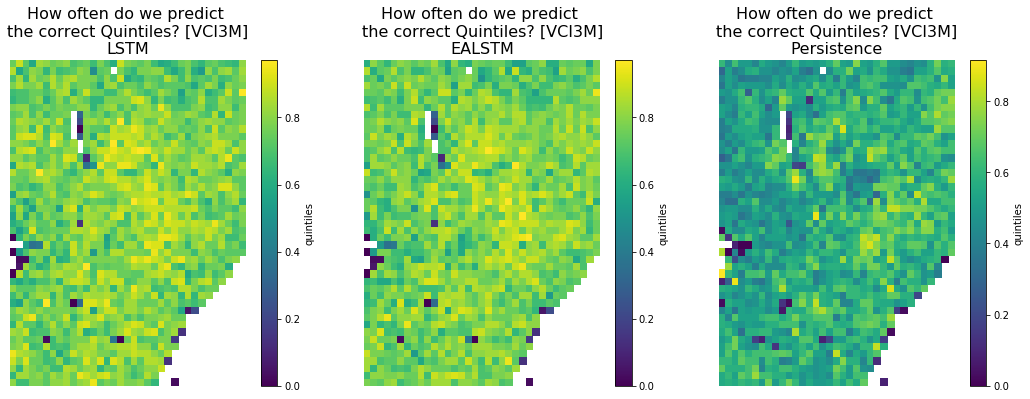

In [75]:
kwargs = {'vmin': 0, 'vmax': 0.8}

fig, axs = plt.subplots(1, 3, figsize=(18,6))
(lstm_pred_qs == true_qs).mean(dim='time').where(~mask).plot(ax=axs[0])
axs[0].set_title(f'How often do we predict \nthe correct Quintiles? [{TARGET_VAR}]\nLSTM', size=16);

(ealstm_pred_qs == true_qs).mean(dim='time').where(~mask).plot(ax=axs[1])
axs[1].set_title(f'How often do we predict \nthe correct Quintiles? [{TARGET_VAR}]\nEALSTM', size=16);

(bline_qs == true_qs).mean(dim='time').where(~mask).plot(ax=axs[2])
axs[2].set_title(f'How often do we predict \nthe correct Quintiles? [{TARGET_VAR}]\nPersistence', size=16);

for ax in axs:
    ax.axis('off')

In [76]:
times = true_qs.time.values
true_np = true_qs.stack(pixel=['lat', 'lon']).values.flatten()
lstm_preds_np = lstm_pred_qs.stack(pixel=['lat', 'lon']).values.flatten()
ealstm_preds_np = ealstm_pred_qs.stack(pixel=['lat', 'lon']).values.flatten()
bline_np = bline_qs.stack(pixel=['lat', 'lon']).values.flatten()

In [77]:
# np.set_printoptions(precision=2)

# plot_confusion_matrix(true_np, preds_np, classes=None, normalize=True,
#                       title='EALSTM Normalized confusion matrix',
#                       **{'vmin': 0.05, 'vmax': 0.35})
# plot_confusion_matrix(true_np, bline_np, classes=None, normalize=True,
#                       title='BASELINE Normalized confusion matrix',
#                       **{'vmin': 0.05, 'vmax': 0.35})

### test vegetation deficit index

    VCI3M Limits   | Description                        | Value
    -----------------------------------------------------------
    0 <= x <10     | Extreme vegetation deficit         |  1
    10 <= x <20    | Severe vegetation deficit          |  2
    20 <= x <35    | Moderate vegetation deficit        |  3
    35 <= x <50    | Normal vegetation conditions       |  4
    50 <= x <=100  | Above normal vegetation conditions |  5


In [78]:
from src.analysis import VegetationDeficitIndex

v = VegetationDeficitIndex(data_dir / 'interim/VCI_preprocessed/data_kenya.nc')
vdi_true = v.vegetation_index_classify(y_test[TARGET_VAR], 'vdi')
vdi_lstm_pred = v.vegetation_index_classify(lstm_pred.load(), 'vdi')
vdi_ealstm_pred = v.vegetation_index_classify(ealstm_pred.load(), 'vdi')
vdi_bline = v.vegetation_index_classify(bline_pred.load(), 'vdi')

print(vdi_true.min(), vdi_true.max())


<xarray.DataArray 'vdi' ()>
array(0) <xarray.DataArray 'vdi' ()>
array(5)


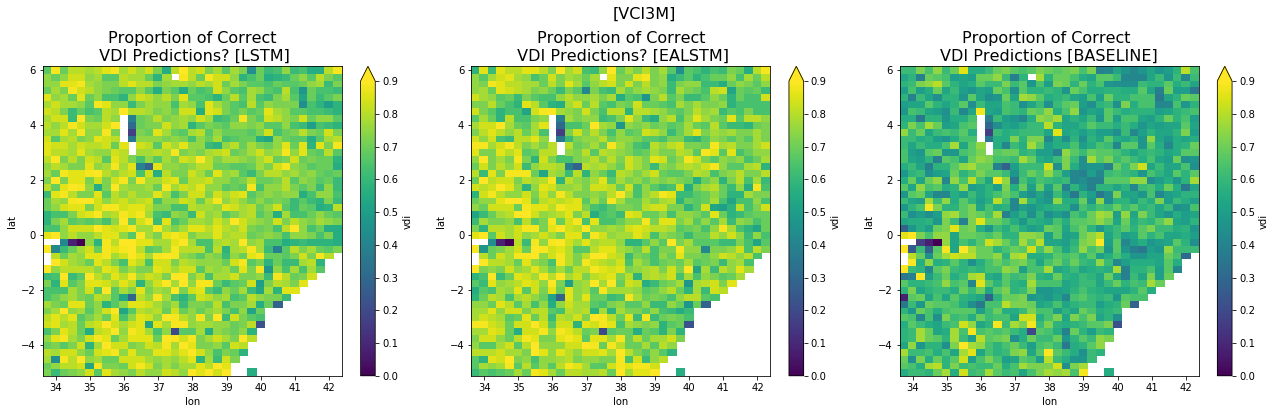

In [82]:
kwargs = {'vmin':0, 'vmax':0.9}

fig, axs = plt.subplots(1, 3, figsize=(18,6))
(vdi_lstm_pred == vdi_true).mean(dim='time').where(~mask).plot(ax=axs[0], **kwargs)
axs[0].set_title('Proportion of Correct\n VDI Predictions? [LSTM]', size=16);

(vdi_ealstm_pred == vdi_true).mean(dim='time').where(~mask).plot(ax=axs[1], **kwargs)
axs[1].set_title('Proportion of Correct\n VDI Predictions? [EALSTM]', size=16);

(vdi_bline == vdi_true).mean(dim='time').where(~mask).plot(ax=axs[2], **kwargs)
axs[2].set_title('Proportion of Correct \nVDI Predictions [BASELINE]', size=16);

fig.suptitle(f'[{TARGET_VAR}]', size=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Plot the Vegetation Deficit Index (VDI) from Klisch & Atzberger 2016

In [83]:
print(true_np.shape)
print(lstm_preds_np.shape)
print(ealstm_preds_np.shape)
print(bline_np.shape)

(56700,)
(56700,)
(56700,)
(56700,)


Normalized confusion matrix
[[0.16998913 0.23305545 0.2232693  0.13030083 0.24338528]
 [0.1081958  0.21328819 0.22443222 0.14797574 0.30610805]
 [0.07920016 0.15977259 0.22760243 0.15830229 0.37512252]
 [0.04735734 0.11552853 0.18264733 0.1902479  0.4642189 ]
 [0.02880935 0.07766684 0.14696713 0.15643869 0.590118  ]]
Normalized confusion matrix
[[0.16998913 0.23305545 0.2232693  0.13030083 0.24338528]
 [0.1081958  0.21328819 0.22443222 0.14797574 0.30610805]
 [0.07920016 0.15977259 0.22760243 0.15830229 0.37512252]
 [0.04735734 0.11552853 0.18264733 0.1902479  0.4642189 ]
 [0.02880935 0.07766684 0.14696713 0.15643869 0.590118  ]]
Normalized confusion matrix
[[0.20097862 0.19300471 0.20659659 0.11471548 0.2847046 ]
 [0.14233319 0.17632952 0.21244181 0.12145578 0.3474397 ]
 [0.1122329  0.14261909 0.19888257 0.14908841 0.39717702]
 [0.07553789 0.10991581 0.17107109 0.15680543 0.48666978]
 [0.04909428 0.07932436 0.1453096  0.15225542 0.57401634]]


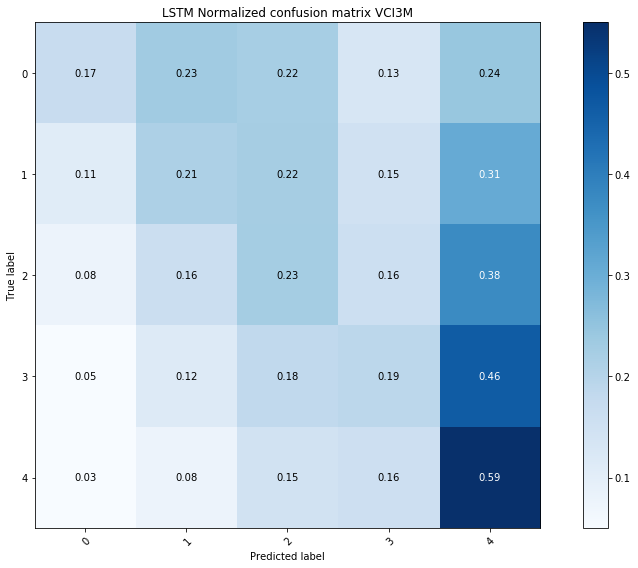

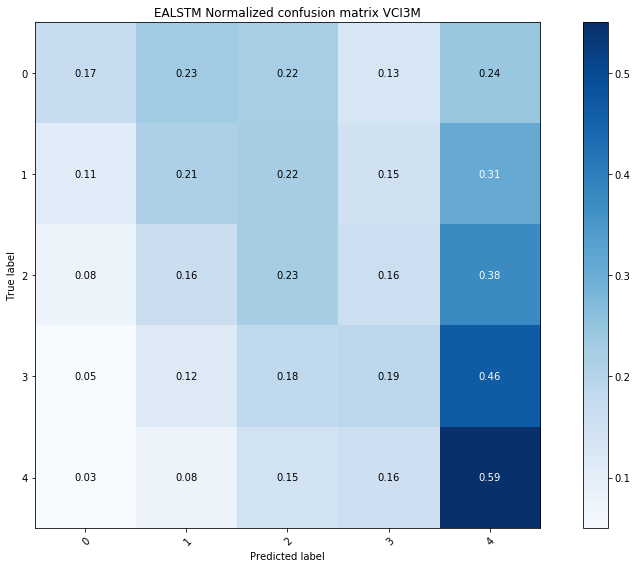

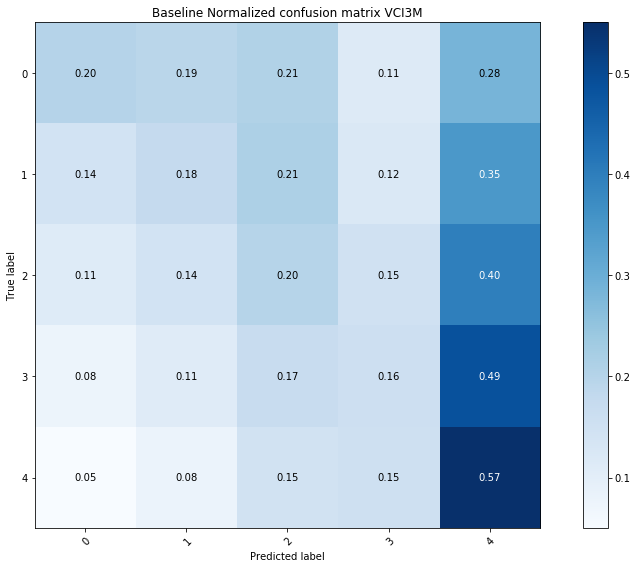

In [85]:
true_np = vdi_true.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
preds_lstm_np = vdi_lstm_pred.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
preds_ealstm_np = vdi_ealstm_pred.stack(pixel=['lat', 'lon']).values.flatten().clip(min=1, max=5)
bline_np = vdi_bline.stack(pixel=['lat', 'lon']).values.flatten()


plot_confusion_matrix(true_np, preds_lstm_np.clip(min=1, max=5), classes=None, normalize=True,
                      title=f'LSTM Normalized confusion matrix {TARGET_VAR}',
                      **{'vmin': 0.05, 'vmax': 0.55});

plot_confusion_matrix(true_np, preds_lstm_np.clip(min=1, max=5), classes=None, normalize=True,
                      title=f'EALSTM Normalized confusion matrix {TARGET_VAR}',
                      **{'vmin': 0.05, 'vmax': 0.55});

plot_confusion_matrix(true_np, bline_np.clip(min=1, max=5), classes=None, normalize=True,
                      title=f'Baseline Normalized confusion matrix {TARGET_VAR}',
                      **{'vmin': 0.05, 'vmax': 0.55});